# Community In The Dark 🦇

## Project overview

This project explores strategic classification, focusing on how a community of agents can collaboratively reverse-engineer a classifier’s decision-making process. Initially, agents can query the classifier without modifying their features to learn its behavior. After gathering insights, they enter a second phase where they strategically adjust their features—at a cost—to maximize acceptance while minimizing individual investment. Our study delves into key machine learning and decision-making concepts, including the exploration-exploitation trade-off, learning dynamics, and social optimization. By systematically varying parameters such as exploration budget, feature modification costs, and classifier complexity, we aim to understand the optimal strategies for balancing learning and adaptation.

We will start by defining our The `SimulationEnv` class represents a simulation environment where agents attempt to modify their features to be accepted by a hidden classifier. Here’s a textual explanation of what it does and contains:

### **Core Functionality:**
1. **Hidden Classifier**:
   - A linear classifier with randomly initialized weights and bias determines whether an agent is "accepted" (label = 1) or "rejected" (label = -1).

2. **Agents**:
   - Each agent has a feature vector and a true label assigned by the hidden classifier.
   - Agents can modify their features to attempt to change their classification.

3. **Cost Functions**:
   - Measures the cost of modifying an agent's feature vector using L1, L2, or L∞ norms.

4. **Exploration Phase**:
   - Some agents' true labels are revealed to collect training data.
   - The collected data is used to train a **proposed SVM classifier**.

5. **Exploitation Phase**:
   - Unexplored agents attempt to improve their classification using the **proposed SVM**.
   - If an agent is initially rejected, it may modify its features in an optimal direction.
   - The modification's cost is compared to a **gain threshold** to determine if the change is beneficial.

6. **Evaluation Metrics**:
   - Measures the accuracy of the **proposed SVM** against the hidden classifier.
   - Computes the percentage of agents accepted before and after modifications.
   - The total cost across all agents is.
   - Utility.

### Total Cost:

$$
C_{\text{total}} = \sum_{i=1}^{N} c(a_i)
$$

### Utility:

$$
U_{\text{total}} = \sum_{i=1}^{N} \left( r(a_i) - c(a_i) \cdot \mathbb{1} \left( \hat{r}(a_i) - c(a_i) > \text{gain\_threshold} \right) \right)
$$

where:

- ( N ) is the total number of agents.
- ($r(a_i)$) is the reward received by agent ($a_i$).
- ($c(a_i)$) is the cost associated with agent ($a_i$).
- ($\hat{r}(a_i)$) is the **perceived** reward of agent ($a_i$) according to the classifier.
- ($\text{gain\_threshold}$) is the minimum threshold for the agent to accept paying the cost.
- ($\mathbb{1}(\cdot)$) is the indicator function, which is 1 if the condition inside holds and 0 otherwise.


### **Interpretation**
- Each agent receives a reward ($r(a_i)$).
- The agent incurs a cost ($c(a_i)$) **only if** its **perceived** reward minus the cost exceeds the gain threshold.
- If \($\hat{r}(a_i) - c(a_i) \leq \text{gain\_threshold} $), the agent does not pay the cost, and only the reward contributes to the total utility.

### **Key Components:**
- `Agent` class: Represents an agent with features, a label, and modification capabilities.
- `cost_l1, cost_l2, cost_linf`: Functions to measure modification costs.
- `SimulationEnv`:
  - Generates agents and assigns true labels.
  - Runs **exploration** to collect training data.
  - Trains an **SVM classifier**.
  - Runs **exploitation** where agents modify their features to be accepted.
  - Measures classifier performance.


### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

### The initial cost functions

In [4]:
def cost_l1(x_old, x_new):
    return np.sum(np.abs(x_new - x_old))

def cost_l2(x_old, x_new):
    return np.linalg.norm(x_new - x_old)

def cost_linf(x_old, x_new):
    return np.max(np.abs(x_new - x_old))


### The initial reward function

In [5]:
def reward_function(label):
    return 1 if label == 1 else -1

### Agents and Community Members

Agents are the community members in our system. Each community member (agent) has a set of defining characteristics (features) and interacts within the environment. The agent may have an assigned true label representing its classification in a given context. Additionally, agents can explore and modify their features under specific conditions.

Each agent needs to have:
- **Features (`features`)**: A vector representing the agent’s characteristics.
- **Initial Features (`initial_features`)**: A stored copy of the original features for baseline measurement and visualization.
- **True Label (`true_label`)**: The actual classification of the agent, assigned by the true classifier.
- **Modification Flag (`modified`)**: A boolean indicating whether the agent has modified its features.
- **Exploration Flag (`explored`)**: A boolean indicating whether the agent has participated in exploration.

### Agent Behavior

The agent can modify its features through the `modify_features` method:
- Takes a `modification` vector as input and applies it to the agent’s features.
- Evaluates the cost of modification using a provided `cost_func`.
- Updates the agent’s features and marks it as modified.
- Returns the computed cost of modification.

This structure allows agents to participate in feature modification and exploration, enabling dynamic adaptation within the community.


In [6]:
class Agent:
    def __init__(self, features, true_label=None):
        self.features = features
        self.initial_features = features.copy()  # store original position for baseline measurement & visualization
        self.true_label = true_label             # assigned by the true classifier
        self.modified = False                    # whether agent has modified its features
        self.explored = False                    # whether the agent participated in exploration

    def modify_features(self, modification, cost_func):
        new_features = self.features + modification
        c = cost_func(self.features, new_features)
        self.features = new_features
        self.modified = True
        return c

### Description of `SimulationEnv` Class

The `SimulationEnv` class simulates a decision-making environment where agents are classified using a hidden classifier, and an alternative classifier (SVM) is trained through exploration. The environment supports both exploration and exploitation phases to refine classification and maximize utility.

#### **Initialization (`__init__` Method)**
- **Parameters:**
  - `hidden_dim` (int): The dimensionality of agent feature vectors.
  - `num_agents` (int): The number of agents in the environment.
  - `cost_function` (str): The cost function used for modifications (options: `'l1'`, `'l2'`, `'linf'`).
- **Key Attributes:**
  - `classifier_weights` and `classifier_bias`: Define the true (hidden) classifier.
  - `proposed_svm`: Stores the trained SVM model.
  - `exploration_data_X` and `exploration_data_y`: Hold training data for the SVM.
  - `agents`: A list of agent objects representing the agent community.

#### **Agent Generation (`generate_agents` Method)**
- Creates agents with random feature vectors.
- Determines each agent's true label using the hidden classifier.
- Ensures there is at least one positive (1) and one negative (-1) agent.

#### **Classification Methods**
- `classify_agent(agent)`: Classifies an agent using the true classifier.
- `proposed_predict(features)`: Predicts an agent's classification using the trained SVM.
- `train_proposed_classifier()`: Trains an SVM on collected exploration data.

#### **Exploration Phase (`run_exploration_phase` Method)**
- Selects a subset of agents for exploration.
- Ensures at least one positive and one negative agent are explored.
- Collects training data and updates the SVM.

#### **Exploitation Phase (`run_exploitation_phase` Method)**
- Attempts to modify agent features to improve classification outcomes.
- Uses the trained SVM to guide modifications.
- Updates utility values based on classification success.

#### **Evaluation Metrics**
- `classifier_understanding_metric()`: Computes accuracy of the trained SVM compared to the true classifier.
- `compute_acceptance_counts()`: Measures the acceptance rates under different scenarios.
- `compute_utility_metrics()`: Evaluates the utility gained from modifications.

This class provides a structured way to analyze classification strategies, explore agent-based decision-making, and evaluate modification costs and rewards.



In [10]:
class SimulationEnv:
    def __init__(self,
                 hidden_dim=10,
                 num_agents=100,
                 cost_function='l1'):
        self.hidden_dim = hidden_dim
        self.num_agents = num_agents

        # Map cost function string to function.
        self.cost_functions = {'l1': cost_l1, 'l2': cost_l2, 'linf': cost_linf}
        if cost_function not in self.cost_functions:
            raise ValueError("Unsupported cost function. Choose from 'l1', 'l2', or 'linf'.")
        self.cost_func = self.cost_functions[cost_function]

        # ----------------------------
        # True (Hidden) Classifier
        # ----------------------------
        self.classifier_weights = np.random.randn(hidden_dim)
        self.classifier_bias = np.random.randn()

        # ----------------------------
        # Proposed Classifier (SVM)
        # ----------------------------
        # This will be trained on exploration data.
        self.proposed_svm = None

        # Containers to hold exploration data.
        self.exploration_data_X = []
        self.exploration_data_y = []

        # Generate the agent community; each agent's true label is determined by the hidden classifier.
        self.agents = self.generate_agents()
        # To store our approach utilities from the exploitation phase.
        self.last_utilities = []
        self.costs = []

    def get_axis_limits(self, margin=1):
        base_positions = np.array([agent.initial_features for agent in self.agents])
        x_min = np.min(base_positions[:, 0]) - margin
        x_max = np.max(base_positions[:, 0]) + margin
        y_min = np.min(base_positions[:, 1]) - margin
        y_max = np.max(base_positions[:, 1]) + margin
        return x_min, x_max, y_min, y_max

    # TODO: Think about addind bias here, maybe ration that we want to have 1 and -1
    def generate_agents(self):
        # This function genreates the agents vectors, which are of dim hidden_dim.
        # Ensure that there is at least one accepted (label 1) and one rejected (label -1) agent.
        while True:
            agents = []
            for _ in range(self.num_agents):
                features = np.random.randn(self.hidden_dim)
                score = np.dot(features, self.classifier_weights) + self.classifier_bias
                label = 1 if score >= 0 else -1
                agent = Agent(features, true_label=label)
                agents.append(agent)
            labels = [agent.true_label for agent in agents]
            if 1 in labels and -1 in labels:
                break
        return agents

    def classify_agent(self, agent):
        score = np.dot(agent.features, self.classifier_weights) + self.classifier_bias
        return 1 if score >= 0 else -1

    def proposed_predict(self, features):
        if self.proposed_svm is None:
            raise ValueError("Proposed SVM has not been trained yet.")
        score = self.proposed_svm.decision_function(features.reshape(1, -1))[0]
        return 1 if score >= 0 else -1

    def train_proposed_classifier(self):
        if len(self.exploration_data_X) == 0:
            return
        X = np.array(self.exploration_data_X)
        y = np.array(self.exploration_data_y)
        # Check if there are at least two distinct classes.
        if len(np.unique(y)) < 2:
            self.proposed_svm = None
            return
        self.proposed_svm = SVC(kernel='linear', C=10)
        self.proposed_svm.fit(X, y)

    def simulation_step(self):
        for agent in self.agents:
            agent.true_label = self.classify_agent(agent)

    def run_exploration_phase(self, exploration_budget=10):
        total_exploration_cost = 0

        # When the budget is at least 2, guarantee that the first two explored agents have different labels.
        if exploration_budget < 2:
            chosen_agents = np.random.choice(self.agents, size=exploration_budget, replace=False)
        else:
            accepted_agents = [agent for agent in self.agents if self.classify_agent(agent) == 1]
            rejected_agents = [agent for agent in self.agents if self.classify_agent(agent) == -1]

            if accepted_agents and rejected_agents:
                first_agent = np.random.choice(accepted_agents)
                second_agent = np.random.choice(rejected_agents)
            else:
                chosen_agents = np.random.choice(self.agents, size=2, replace=False)
                first_agent, second_agent = chosen_agents[0], chosen_agents[1]

            remaining_agents = [agent for agent in self.agents if agent not in [first_agent, second_agent]]
            remaining_budget = exploration_budget - 2

            if remaining_budget > 0:
                additional_agents = np.random.choice(remaining_agents, size=remaining_budget, replace=False)
                chosen_agents = [first_agent, second_agent] + list(additional_agents)
            else:
                chosen_agents = [first_agent, second_agent]

        for agent in chosen_agents:
            true_label = self.classify_agent(agent)
            agent.true_label = true_label
            agent.explored = True
            self.exploration_data_X.append(agent.features.copy())
            self.exploration_data_y.append(true_label)
            total_exploration_cost += 1
            self.last_utilities.append(true_label)

        self.train_proposed_classifier()
        return total_exploration_cost

    def apply_investment(self, agent, modification):
        cost_incurred = agent.modify_features(modification, self.cost_func)
        new_true_label = self.classify_agent(agent)
        reward = reward_function(new_true_label)
        utility = reward - cost_incurred
        return utility, cost_incurred, reward, new_true_label

    def run_exploitation_phase(self, retrain_every = None):
        utilities = []
        gain_threshold = 2
        iter = 0
        for agent in self.agents:
            if agent.explored:
                utilities.append(reward_function(agent.true_label))
                continue

            true_label = self.classify_agent(agent)
            if true_label == 1:
                utilities.append(reward_function(true_label))
                continue

            if self.proposed_svm is None:
                utilities.append(reward_function(true_label))
                continue

            f_prop = self.proposed_svm.decision_function(agent.features.reshape(1, -1))[0]
            if f_prop >= 0:
                utilities.append(reward_function(true_label))
            else:
                iter += 1
                weight_vector = self.proposed_svm.coef_[0]
                norm_w = np.linalg.norm(weight_vector)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = weight_vector / norm_w
                alpha_min = -f_prop / norm_w
                projected_features = agent.features + alpha_min * d_unit
                projected_cost = self.cost_func(agent.features, projected_features)
                if projected_cost < gain_threshold:
                    self.costs.append(projected_cost)
                    util, _, _, new_true_label = self.apply_investment(agent, alpha_min * d_unit)
                    utilities.append(util)
                    self.exploration_data_X.append(agent.features.copy())
                    self.exploration_data_y.append(new_true_label)
                    if retrain_every and iter % retrain_every == 0:
                      self.train_proposed_classifier()
                else:
                    utilities.append(reward_function(true_label))
        self.last_utilities = utilities
        return utilities

    def classifier_understanding_metric(self, num_samples=1000):
        if self.proposed_svm is None:
            raise ValueError("Proposed classifier is not trained yet.")
        samples = np.random.randn(num_samples, self.hidden_dim)
        true_scores = np.dot(samples, self.classifier_weights) + self.classifier_bias
        true_labels = np.where(true_scores >= 0, 1, -1)
        svm_predictions = self.proposed_svm.predict(samples)
        accuracy = np.mean(true_labels == svm_predictions)
        return accuracy

    def compute_acceptance_counts(self, gain_threshold=2):
        optimal_modification_acceptance = 0
        no_modification_acceptance = 0
        for agent in self.agents:
            initial_score = np.dot(agent.initial_features, self.classifier_weights) + self.classifier_bias
            if initial_score >= 0:
                no_modification_acceptance += 1
                optimal_modification_acceptance += 1
            else:
                norm_w = np.linalg.norm(self.classifier_weights)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = self.classifier_weights / norm_w
                alpha_min_true = -initial_score / norm_w
                modification = alpha_min_true * d_unit
                cost_required = self.cost_func(agent.initial_features, agent.initial_features + modification)
                if cost_required < gain_threshold:
                    optimal_modification_acceptance += 1
        our_approach_acceptance = sum(1 for agent in self.agents if self.classify_agent(agent) == 1)
        return optimal_modification_acceptance, no_modification_acceptance, our_approach_acceptance

    def compute_metrics(self, gain_threshold=2):
        no_mod_util = 0.0
        optimal_util = 0.0
        optimal_cost = 0
        for agent in self.agents:
            init_score = np.dot(agent.initial_features, self.classifier_weights) + self.classifier_bias
            if init_score >= 0:
                no_mod_util += 1
                optimal_util += 1
            else:
                no_mod_util += -1
                norm_w = np.linalg.norm(self.classifier_weights)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = self.classifier_weights / norm_w
                alpha_min_true = -init_score / norm_w
                candidate = agent.initial_features + alpha_min_true * d_unit
                cost_required = self.cost_func(agent.initial_features, candidate)
                if cost_required < gain_threshold:
                    optimal_cost += cost_required
                    optimal_util += (1 - cost_required)
                else:
                    optimal_util += -1

        our_util = sum(self.last_utilities) if self.last_utilities is not None else None
        our_cost = sum(self.costs) if self.costs is not None else None
        return optimal_util, no_mod_util, our_util, optimal_cost, 0, our_cost

    def reset_simulation(self):
        for agent in self.agents:
            agent.features = agent.initial_features.copy()
            agent.modified = False
            agent.explored = False
        self.exploration_data_X = []
        self.exploration_data_y = []
        self.proposed_svm = None
        self.last_utilities = []
        self.costs = []

    def plot_environment(self):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        self.simulation_step()

        accepted_list = []
        denied_list = []
        modified_list = []
        for agent in self.agents:
            label = self.classify_agent(agent)
            if label == 1:
                accepted_list.append(agent.features)
            else:
                denied_list.append(agent.features)
            if agent.modified:
                modified_list.append(agent.features)

        accepted = np.array(accepted_list)
        denied = np.array(denied_list)
        modified_points = np.array(modified_list)

        plt.figure(figsize=(8, 6))
        if accepted.shape[0] > 0:
            plt.scatter(accepted[:, 0], accepted[:, 1], c='green', label='Accepted')
        if denied.shape[0] > 0:
            plt.scatter(denied[:, 0], denied[:, 1], c='red', label='Denied')
        if modified_points.shape[0] > 0:
            plt.scatter(modified_points[:, 0], modified_points[:, 1],
                        facecolors='none', edgecolors='blue', s=100, linewidths=1.5,
                        label='Modified Agents')

        for agent in self.agents:
            if agent.modified:
                x_old, y_old = agent.initial_features[0], agent.initial_features[1]
                x_new, y_new = agent.features[0], agent.features[1]
                plt.arrow(x_old, y_old, x_new - x_old, y_new - y_old,
                          head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.7)

        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0] * x_values) / self.classifier_weights[1]
            plt.plot(x_values, y_values, 'b--', label='True Decision Boundary')
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            plt.axvline(x=x_boundary, color='b', linestyle='--', label='True Decision Boundary')

        if self.proposed_svm is not None:
            coef = self.proposed_svm.coef_[0]
            intercept = self.proposed_svm.intercept_[0]
            if coef[1] != 0:
                y_values_prop = (-intercept - coef[0]*x_values) / coef[1]
                plt.plot(x_values, y_values_prop, 'k--', label='Proposed Decision Boundary')
            else:
                x_boundary_prop = -intercept / coef[0]
                plt.axvline(x=x_boundary_prop, color='k', linestyle='--', label='Proposed Decision Boundary')

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.title('Agent Distribution, Classifiers, and Modified Agents (Our Approach)')
        plt.show()

    def plot_optimal_modification_scenario(self, gain_threshold=2):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        final_positions = []
        modifications = []
        accepted_indices = []

        for idx, agent in enumerate(self.agents):
            init_feat = agent.initial_features.copy()
            score = np.dot(init_feat, self.classifier_weights) + self.classifier_bias

            if score >= 0:
                final_positions.append(init_feat)
                modifications.append(None)
                accepted_indices.append(idx)
            else:
                w = self.classifier_weights
                norm_w = np.linalg.norm(w)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = w / norm_w
                alpha_min_true = -score / norm_w
                candidate = init_feat + alpha_min_true * d_unit
                cost_required = self.cost_func(init_feat, candidate)
                if cost_required < gain_threshold:
                    final_positions.append(candidate)
                    modifications.append(candidate - init_feat)
                    final_score = np.dot(candidate, self.classifier_weights) + self.classifier_bias
                    if final_score >= 0:
                        accepted_indices.append(idx)
                else:
                    final_positions.append(init_feat)
                    modifications.append(None)

        final_positions = np.array(final_positions)
        plt.figure(figsize=(8, 6))

        accepted_pts = final_positions[[i for i in accepted_indices]]
        denied_pts = np.delete(final_positions, accepted_indices, axis=0)

        if accepted_pts.size > 0:
            plt.scatter(accepted_pts[:, 0], accepted_pts[:, 1], c='green', label='Accepted (Optimal True)')
        if denied_pts.size > 0:
            plt.scatter(denied_pts[:, 0], denied_pts[:, 1], c='red', label='Denied (Optimal True)')

        for i, mod_vec in enumerate(modifications):
            if mod_vec is not None:
                start_x, start_y = self.agents[i].initial_features
                plt.arrow(start_x, start_y, mod_vec[0], mod_vec[1],
                          head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.7)

        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0] * x_values) / self.classifier_weights[1]
            plt.plot(x_values, y_values, 'b--', label='True Decision Boundary')
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            plt.axvline(x=x_boundary, color='b', linestyle='--', label='True Decision Boundary')

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Optimal Modifications (Full Knowledge of True Classifier)')
        plt.legend()
        plt.show()

    def plot_base_version(self):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        base_positions = np.array([agent.initial_features for agent in self.agents])
        true_scores = np.dot(base_positions, self.classifier_weights) + self.classifier_bias
        base_labels = np.where(true_scores >= 0, 1, -1)

        accepted = base_positions[base_labels == 1]
        denied = base_positions[base_labels == -1]

        plt.figure(figsize=(8, 6))
        if accepted.shape[0] > 0:
            plt.scatter(accepted[:, 0], accepted[:, 1], c='green', label='Accepted')
        if denied.shape[0] > 0:
            plt.scatter(denied[:, 0], denied[:, 1], c='red', label='Denied')

        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0] * x_values) / self.classifier_weights[1]
            plt.plot(x_values, y_values, 'b--', label='True Decision Boundary')
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            plt.axvline(x=x_boundary, color='b', linestyle='--', label='True Decision Boundary')

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.title('Base Version: Agent Distribution (Initial Features)')
        plt.show()


### Explanation of the Experiment

This script simulates an agent-based environment where agents explore and exploit information using a cost function (in this case, the L2 norm). The goal is to analyze the agents' decision-making process and evaluate different strategies for maximizing utility.

#### **1. Initialization**
- A random seed (`seed = 0`) is set to ensure reproducibility.
- The environment (`SimulationEnv`) is initialized with:
  - `hidden_dim=2`: The agents operate in a two-dimensional hidden space.
  - `num_agents=100`: There are 100 agents in the simulation.
  - `cost_function='l2'`: The cost function used is the L2 norm (Euclidean distance).

#### **2. Exploration Phase**
- The script runs an **exploration phase** with a budget of 30.
- The exploration phase allows agents to explore the environment, gathering information at a cost.
- The first two agents always have different labels, ensuring a minimal level of diversity in initial exploration.
- The script prints:
  - The number of agents that acted as explorers.
  - The number of agents that acted as exploiters (agents that benefited from exploration without additional cost).

#### **3. Classifier Understanding**
- A classifier is evaluated using the `classifier_understanding_metric` function with 1000 samples.
- This step measures how well the classifier understands the environment after the exploration phase.

#### **4. Exploitation Phase**
- The script runs the **exploitation phase**, where agents use the gathered information to maximize their utility.
- The utilities of all agents are computed, and the total utility is summed.

#### **5. Performance Evaluation**
- **Acceptance Metrics**:
  The script evaluates the proportion of agents that meet a certain acceptance criterion (`gain_threshold=2`), under three conditions:
  - **No Modification:** The baseline case without any interventions.
  - **Optimal Modification:** The best possible intervention scenario.
  - **Our Approach:** The proposed approach without retraining.
- **Metrics:**
  The metrics explained above


#### **6. Visualization**
- The script generates and displays three visualizations:
  1. `plot_base_version()`: Shows the original scenario before modifications.
  2. `plot_optimal_modification_scenario(gain_threshold=2)`: Illustrates the best-case modification.
  3. `plot_environment()`: Provides an overview of the agent-based simulation.


Initial Agents: 100
Explorers: 30  |  Exploiters: 70
Classifier Understanding Accuracy: 0.995
No Modification Acceptance: 24 / 100  | Total Utility: -52.0 | Total Cost: 0
Optimal Modification Acceptance: 89 / 100  | Total Utility: 28.079859956436717 | Total Cost: 49.92014004356326
Our Approach Acceptance without retraining: 30 / 100  | Total Utility: -75.96836845726418 | Total Cost: 35.968368457264205


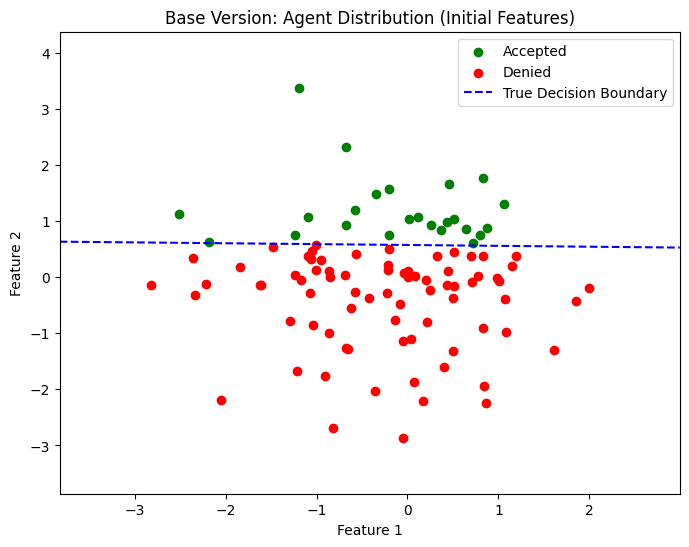

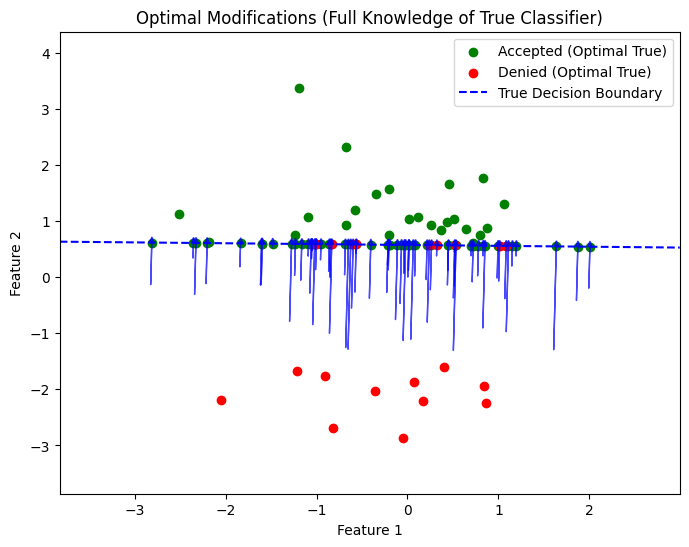

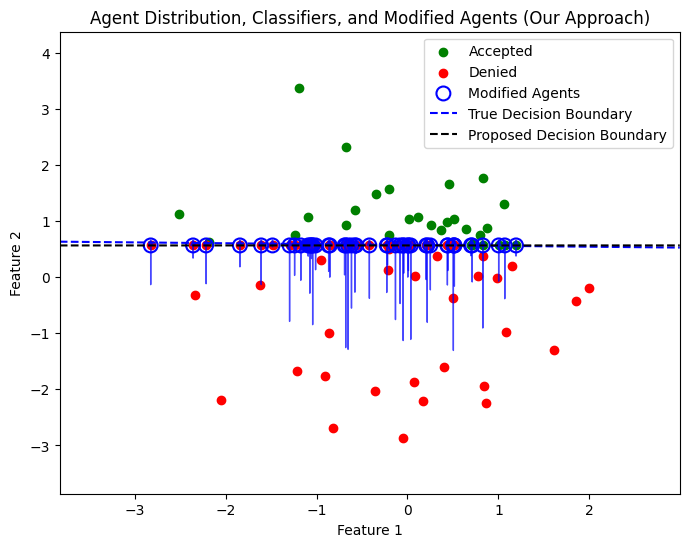

In [14]:
if __name__ == "__main__":
    seed = None
    np.random.seed(seed)

    env = SimulationEnv(hidden_dim=2, num_agents=100, cost_function='l1')

    print("Initial Agents:", len(env.agents))
    exploration_cost = env.run_exploration_phase(exploration_budget=30)  # Note: the first two agents always have different labels (exploration budget must be greater than 2)
    print("Explorers:", exploration_cost, " | ", "Exploiters:", len(env.agents) - exploration_cost)

    understanding_accuracy = env.classifier_understanding_metric(num_samples=1000)
    print("Classifier Understanding Accuracy:", understanding_accuracy)

    our_utilities = env.run_exploitation_phase()

    optimal_acc, no_mod_acc, our_acc = env.compute_acceptance_counts(gain_threshold=2)
    optimal_util, no_mod_util, our_util, optimal_cost, _ , our_cost = env.compute_metrics(gain_threshold=2)
    print("No Modification Acceptance:", no_mod_acc, "/", len(env.agents), " | Total Utility:", no_mod_util, "| Total Cost:", 0)
    print("Optimal Modification Acceptance:", optimal_acc, "/", len(env.agents), " | Total Utility:", optimal_util, "| Total Cost:", optimal_cost)
    print("Our Approach Acceptance without retraining:", our_acc, "/", len(env.agents), " | Total Utility:", our_util, "| Total Cost:", our_cost)

    # Plot the original graphs.
    env.plot_base_version()
    env.plot_optimal_modification_scenario(gain_threshold=2)
    env.plot_environment()


# Retraining every 10

Our Approach Acceptance without retraining: 42 / 100  | Total Utility: -50.27552893378884 | Total Cost: 34.27552893378882


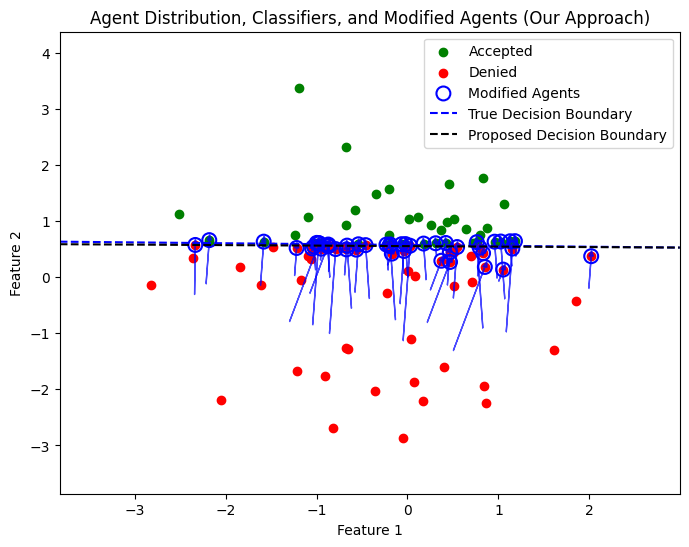

In [17]:
env.reset_simulation()
exploration_cost = env.run_exploration_phase(exploration_budget=30)
our_utilities = env.run_exploitation_phase(retrain_every = 10)
_, _, our_acc = env.compute_acceptance_counts(gain_threshold=2)
_, _, our_util, _, _ , our_cost = env.compute_metrics(gain_threshold=2)

print("Our Approach Acceptance without retraining:", our_acc, "/", len(env.agents), " | Total Utility:", our_util, "| Total Cost:", our_cost)
env.plot_environment()

# Retraining every 1

In [ ]:
env.reset_simulation()
exploration_cost = env.run_exploration_phase(exploration_budget=30)
our_utilities = env.run_exploitation_phase(retrain_every = 1)
_, _, our_acc = env.compute_acceptance_counts(gain_threshold=2)
_, _, our_util, _, _ , our_cost = env.compute_metrics(gain_threshold=2)

print("Our Approach Acceptance without retraining:", our_acc, "/", len(env.agents), " | Total Utility:", our_util, "| Total Cost:", our_cost)
env.plot_environment()

#Hypothesis 1 (Exploration Budget)

# Conjecture

Increasing the exploration budget should provide the community with more labeled examples from the hidden classifier. With more exploration, the proposed SVM classifier has a better chance of approximating the true decision boundary, which improves the overall understanding of the classifier. However, after a certain point, adding more exploration data may yield diminishing returns in the final acceptance rate. In other words, while the classifier’s understanding (measured via accuracy) improves with more exploration, the increase in the proportion of accepted agents will eventually level off.

# Testing Strategy

To test this hypothesis, we will run a series of simulations where the exploration budget is incrementally varied. For each exploration budget, we will:

1. **Run the Exploration Phase:**  
   Collect labeled data from a subset of agents using the current exploration budget.
   
2. **Evaluate Classifier Understanding:**  
   Compute the classifier's accuracy against a set of randomly generated samples to assess how well the proposed SVM approximates the true decision boundary.
   
3. **Run the Exploitation Phase:**  
   Allow the agents to modify their features based on the classifier's predictions.
   
4. **Compute the Final Acceptance Rate:**  
   Determine the proportion of agents classified as accepted after the exploitation phase.

Finally, we will plot the classifier understanding accuracy and the final acceptance rate as functions of the exploration budget. These plots will help us determine whether increasing exploration leads to diminishing returns in terms of increasing the acceptance rate.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set a fixed random seed for reproducibility
np.random.seed(0)

# Set a larger number of agents
num_agents = 2000

# Define exploration budgets that span from a small value up to half of num_agents
max_budget = num_agents // 2  # half of the agents
exploration_budgets = np.linspace(2, max_budget, num=100, dtype=int)  # 100 values from 2 to 1000

# Lists to store the results for each exploration budget
understanding_accuracies = []
acceptance_rates = []

# Create a single simulation environment instance
env = SimulationEnv(hidden_dim=2, num_agents=num_agents, cost_function='l1')

for budget in exploration_budgets:
    # Reset the simulation to its initial state before each run
    env.reset_simulation()
    
    # Run the exploration phase with the current budget
    env.run_exploration_phase(exploration_budget=budget)
    
    # Evaluate classifier understanding using 1000 random samples
    understanding_accuracy = env.classifier_understanding_metric(num_samples=1000)
    
    # Run the exploitation phase where agents modify their features
    env.run_exploitation_phase()
    
    # Compute the acceptance counts for our approach
    _, _, our_acc = env.compute_acceptance_counts(gain_threshold=2)
    acceptance_rate = our_acc / len(env.agents)
    
    # Store the results
    understanding_accuracies.append(understanding_accuracy)
    acceptance_rates.append(acceptance_rate)

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot for Classifier Understanding Accuracy vs Exploration Budget
plt.subplot(1, 2, 1)
plt.plot(exploration_budgets, understanding_accuracies, marker='o')
plt.xlabel('Exploration Budget')
plt.ylabel('Classifier Understanding Accuracy')
plt.title('Classifier Understanding vs Exploration Budget')

# Plot for Final Acceptance Rate vs Exploration Budget
plt.subplot(1, 2, 2)
plt.plot(exploration_budgets, acceptance_rates, marker='o', color='orange')
plt.xlabel('Exploration Budget')
plt.ylabel('Final Acceptance Rate')
plt.title('Acceptance Rate vs Exploration Budget')

plt.tight_layout()
plt.show()
